<a href="https://colab.research.google.com/github/fbeilstein/machine_learning/blob/master/workbook_13_k_means_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# k-means clustering with sklearn

Use the following demo to gain some intuition on $k$-means.
You can change number of clusters by setting `n_clusters` variable.
Consider different settings, try reclusterizing the same arrangement of points to see how randomness influences the result.

In [1]:
from sklearn.cluster import KMeans

kmeans = KMeans()

def cluster(X, n):
  kmeans.set_params(n_clusters=n)
  kmeans.fit(X)
  y_kmeans = kmeans.predict(X)
  centers = kmeans.cluster_centers_
  return y_kmeans, centers

def classify(X):
  return kmeans.predict(X)

In [2]:
#@title k-means on 2D points
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_clusters(X, y, center, xx, yy, Z):
  fig = plt.figure(figsize=(10,10))
  ax = fig.gca()
  ax.tick_params(axis="y",direction="in", pad=-40)
  ax.tick_params(axis="x",direction="in", pad=-15)
  ax.set_xticks(np.arange(-.75, 1, .25))
  ax.set_yticks(np.arange(-.75, 1, .25))
  ax.set_xlim([-1, 1])
  ax.set_ylim([-1, 1])

  plt.scatter(X[:, 0], X[:, 1], c=y, s=150, cmap='viridis')
  # see https://matplotlib.org/3.1.1/api/markers_api.html
  plt.scatter(center[:, 0], center[:, 1], c=range(len(center)), marker='s', s=200, alpha=0.7);
  
  # Put the result into a color plot
  n_classes = len(center)
  Z = Z.reshape(xx.shape)
  contours = ax.contourf(xx, yy, Z, alpha=0.2, levels=np.arange(n_classes + 1) - 0.5, cmap='viridis', zorder=1)
  
  plt.close(fig)

  return fig

import base64
import io

def figure_to_base64(fig):
  buf = io.BytesIO()
  fig.savefig(buf, format='png', bbox_inches='tight', pad_inches=0);
  image_base64 = base64.b64encode(buf.getvalue()).decode('utf-8').replace('\n', '')
  buf.close()
  return image_base64

import json

def invoke(n_clusters, pts):
  data = np.array(pts).reshape((-1, 2))
  X = data / 300.0 - 1.0
  X[:, 1] *= -1.0

  y_kmeans, centers = cluster(X, int(n_clusters))

  # fit the estimator
  xlim = [-1.0, 1.0]
  ylim = [-1.0, 1.0]
  xx, yy = np.meshgrid(np.linspace(*xlim, num=700), np.linspace(*ylim, num=700))
  Z = classify(np.c_[xx.ravel(), yy.ravel()])

  fig = plot_clusters(X, y_kmeans, centers, xx, yy, Z)

  image_base64 = figure_to_base64(fig)
  return IPython.display.JSON({'image': image_base64})


import IPython
from google.colab import output

main_str = '''
  <script type="application/javascript">
  
    var active_pt = null;
    var all_pts = [];
    var classAbtn = [650, 100];
    var classBbtn = [650, 200];
    var ptR = 10.0;
    var params = null;
    var debug_txt = "";
    var bg_image = new Image();

    function is_close(pt1, pt2) {
      return   (pt1[0] - pt2[0])*(pt1[0] - pt2[0])
            +  (pt1[1] - pt2[1])*(pt1[1] - pt2[1])
            <= ptR*ptR;
    }
  
    function circ(ctx, pos) {
      ctx.beginPath();
      ctx.arc(pos[0], pos[1], ptR, 0.0, 2.0 * Math.PI, 0);
      ctx.fillStyle = 'rgba(50, 50, 50, 0.3)';
      ctx.fill();
    }
    
    
    function draw() {
      var canvas = document.getElementById('canvas');
      if (canvas.getContext) {
        var ctx = canvas.getContext('2d');
        
        ctx.clearRect(0, 0, canvas.width, canvas.height); // cleanup before start
        ctx.drawImage(bg_image, 0, 0, 600, 600);
        ctx.strokeRect(0, 0, 600, 600); // field
        
        ctx.font = '20px serif';
        ctx.fillStyle = 'black';
        ctx.fillText(debug_txt, 200, 200);
        
        if (active_pt) {
          circ(ctx, [active_pt[0], active_pt[1]]);
        }
        all_pts.forEach(function (item, index) {
          circ(ctx, [item[0], item[1]]);
        });
        
        
        
      }
    }
    
    var timer
    function init() {
      timer = setInterval(draw, 10);
    }

    function get_state() {
      var rates = document.getElementsByName('rate');
      for(var i = 0; i < rates.length; i++)
        if(rates[i].checked)
          return rates[i].value;
      return "none";
    }

    
    function mdown_handle(evt) {
      x = evt.offsetX;
      y = evt.offsetY;
      state = get_state();
      if (state == "add") {
        if (x < 600)
            all_pts.push([x, y]);
        return;
      }

      idx = -1;
      all_pts.forEach(function (item, index) {
        if (is_close([x,y], [item[0], item[1]])) {
          idx = index;
        }
      });
      if (idx <= -1)
          return;
      if (state == "move") {
        active_pt = all_pts[idx];
        all_pts.splice(idx, 1);
      }
      if (state == "del")
          all_pts.splice(idx, 1);
    }
    
    function mmove_handle(evt) {
      if (get_state() != "move")
          return;
      x = evt.offsetX;
      y = evt.offsetY;
      if (active_pt) {
        active_pt[0] = x;
        active_pt[1] = y;
      }
    }
    
    function mup_handle(evt) {
      if (get_state() != "move")
          return;
      x = evt.offsetX;
      y = evt.offsetY;
      if (x >= 600) {
        active_pt = null;
      }
      if (active_pt) {
        all_pts.push(active_pt);
        active_pt = null;
      }
    }
    
    function clear_field() {
      active_pt = null;
      all_pts = [];
    }

    var num_clusters = 1;

    async function calculate() {
      if (!all_pts)
        return;
      var merged = [].concat.apply([], all_pts);
      const result = await google.colab.kernel.invokeFunction('notebook.InvSVM', [num_clusters, merged], {});
      params = result.data['application/json'];
      bg_image.src = 'data:image/  png;base64,' + params.image;
    }

   function h_change(x) {
    el = document.getElementById("slider_val");
    num_clusters = x;
    if (x)
       el.innerHTML = x;
    else
       el.innerHTML = "Auto";
  }
  </script>
  <canvas id="canvas" width="800" height="600" 
    onmousedown="mdown_handle(event)"
    onmousemove="mmove_handle(event)"
    onmouseup="mup_handle(event)"></canvas>
  <div style="position:absolute; top:275px; left:625px;">
   <div style="border-style: solid;">
    <input type="radio" id="r1" name="rate" value="add" checked="checked">
    <label for="r1">
      Add data point
    </label>
    <br>
    <input type="radio" id="r2" name="rate" value="move">
    <label for="r2">
      Move data point
    </label>
    <br>
    <input type="radio" id="r3" name="rate" value="del">
    <label for="r3">
      Delete data point
    </label>
    <br>
    <button type="button" onclick="clear_field();">
      Clear
    </button>
   </div>
   <br><br>Search for # of clusters:<br>
    <input type="range" min="1" max="9" value="1" oninput="h_change(this.value)">
    <br><div id="slider_val">1</div>
   <br><br>
    <button type="button" onclick="calculate();">
      Cluster
    </button>
  </div>
  <script> init();</script>
'''



def generate_html():
  s = main_str
  return s
  
display(IPython.display.HTML(generate_html()))
    
    
output.register_callback('notebook.InvSVM', invoke)

#Simplest custom k-means implementation

Implement the simplest possible $k$-means and integrate it with the visualizaion.
To do this complete the following code according to instructions given.
Your function will get three variables
* `X` -- pairs of numbers, represent points on the plane. This is the data you need to clusterize.
* `n_clusters` -- number of clusters you should generate.
* `callback` -- function you should call on every iteration. This is needed for further visualization.

1. Randomly choose initial cluster centers. Place the result into the `centers` variable. You can use randomly chosen points of `X` as cluster centers but be sure they do not overlap (all centers are distinct).
2. Assign each point from `X` a label (number from `0` to `n_clusters - 1`) that represents the cluster it belongs to (choose the closest center). Put the result into the `labels` variable.
3. Reevaluate cluster centers as barycenters (mean values) of points that belong to correspong clusters. Set `new_centers` variable equal to new centers.

Explore the result with visualization code given.

In [ ]:
# a very basic implementation of k-means

from sklearn.metrics import pairwise_distances_argmin
import numpy as np

def find_clusters(X, initial_centers, callback):
  history = []
  centers = initial_centers
  n_clusters = len(initial_centers)

  while True:
    # Assign labels based on closest center
    labels =

    # Find new centers from means of points
    # Watch empty clusters!
    new_centers = 

    callback(centers, labels)
    # Check for convergence
    if np.all(centers == new_centers):
      break
    centers = new_centers

  return centers, labels

In [ ]:
#@title Custom k-means on 2D points


import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import cm
import seaborn as sns
from sklearn.metrics import pairwise_distances_argmin
        
def plot_clusters(X, y, center):
  sns.set();
  fig = plt.figure(figsize=(10,10))
  ax = fig.gca()
  ax.tick_params(axis="y",direction="in", pad=-40)
  ax.tick_params(axis="x",direction="in", pad=-15)
  ax.set_xticks(np.arange(-.75, 1, .25))
  ax.set_yticks(np.arange(-.75, 1, .25))
  ax.set_xlim([-1, 1])
  ax.set_ylim([-1, 1])

  n_classes = int(len(center))
  ax.scatter(X[:, 0], X[:, 1], c=y, s=150, cmap='viridis', vmin=0.0, vmax=(n_classes+0.5))
  # see https://matplotlib.org/3.1.1/api/markers_api.html
  sq_clrs=[float(x)+0.1 for x in range(n_classes)]
  ax.scatter(center[:, 0], center[:, 1], cmap='viridis', c=np.array(sq_clrs), marker='s', s=200, vmin=0.0, vmax=(n_classes+0.5));

  # fit the estimator
  xx, yy = np.meshgrid(np.linspace(-1.0, 1.0, num=700), np.linspace(-1.0, 1.0, num=700))
  Z = pairwise_distances_argmin(np.c_[xx.ravel(), yy.ravel()], center)

  # Put the result into a color plot
  n_classes = len(center)
  Z = Z.reshape(xx.shape)
  contours = ax.contourf(xx, yy, Z, alpha=0.3, levels=np.arange(n_classes + 1) - 0.5, cmap='viridis', zorder=1)
  
  plt.close(fig)

  return fig

import base64
import io

def figure_to_base64(fig):
  buf = io.BytesIO()
  fig.savefig(buf, format='png', bbox_inches='tight', pad_inches=0);
  image_base64 = base64.b64encode(buf.getvalue()).decode('utf-8').replace('\n', '')
  buf.close()
  return image_base64

def get_lines(X, centers, labels):
  classes = np.unique(labels)
  lines = []
  for c in classes:
    from_pts = centers[c]
    to_pts = X[labels == c]
    for p in to_pts:
      lines = lines + [from_pts, p, np.array([None, None])]
  return np.array(lines)

import json
from IPython.display import display, clear_output

history = []
def collect_history(centers, labels):
  global history
  history += [[centers.tolist(), labels.tolist()]]

def invoke(pts):
  data = np.array(pts).reshape((-1, 3))
  data_points = data[data[:,2] == 0][:,:2]
  data_centers = data[data[:,2] == 1][:,:2]
  X = data_points / 300.0 - 1.0
  X[:, 1] *= -1.0
  i_C = data_centers / 300.0 - 1.0
  i_C[:, 1] *= -1.0
  global history
  history = []
  centers, labels = find_clusters(X, i_C, collect_history)
  figr = plot_clusters(X, labels, centers)
  image_base64 = figure_to_base64(figr)

  history = np.array(history)
  centers_history = history[:, 0]
  labels_history  = history[:, 1]
  connections_history = [get_lines(X, c, l) for c,l in zip(centers_history, labels_history)]
  connections_X = [c[:, 0].tolist() for c in connections_history]
  connections_Y = [c[:, 1].tolist() for c in connections_history]


  centers[:, 1] *= -1.0
  centers = (centers + 1.0) * 300.0
  c_x = [[c[0] for c in center] for center in centers_history]
  c_y = [[c[1] for c in center] for center in centers_history]

  return IPython.display.JSON({'image': image_base64, 
                               'centers': centers.tolist(), 
                               'labels_history': labels_history.tolist(),
                               'conn_x_hist': connections_X,
                               'conn_y_hist': connections_Y,
                               'pts_x': X[:, 0].tolist(),
                               'pts_y': X[:, 1].tolist(),
                               'c_x': c_x,
                               'c_y': c_y}) 


import IPython
from google.colab import output

main_str = '''
  <script src="https://cdn.plot.ly/plotly-latest.min.js"></script> 
  <script type="application/javascript">
  
    var active_pt = null;
    var all_pts = [];
    var ptR = 10.0;
    var params = null;
    var debug_txt = "";
    var bg_image = new Image();

    function is_close(pt1, pt2) {
      return   (pt1[0] - pt2[0])*(pt1[0] - pt2[0])
            +  (pt1[1] - pt2[1])*(pt1[1] - pt2[1])
            <= ptR*ptR;
    }
  
    function circ(ctx, pos) {
      ctx.beginPath();
      ctx.fillStyle = 'rgba(128, 128, 128, 0.5)';
      if (pos[2] == 0) {
          ctx.arc(pos[0], pos[1], ptR, 0.0, 2.0 * Math.PI, 0);
          ctx.fill();
      } else {
          ctx.fillRect(pos[0] - ptR, pos[1] - ptR, 2 * ptR, 2 * ptR);
      }
    }
    
    
    function draw() {
      var canvas = document.getElementById('canvas');
      if (canvas.getContext) {
        var ctx = canvas.getContext('2d');
        
        ctx.clearRect(0, 0, canvas.width, canvas.height); // cleanup before start
        ctx.drawImage(bg_image, 0, 0, 600, 600);
        ctx.strokeRect(0, 0, 600, 600); // field
        
        ctx.font = '20px serif';
        ctx.fillStyle = 'black';
        ctx.fillText(debug_txt, 200, 200);
        
        if (active_pt) {
          circ(ctx, active_pt);
        }
        all_pts.forEach(function (item, index) {
          circ(ctx, item);
        });

      }
    }
    
    var timer

    function get_state() {
      var rates = document.getElementsByName('rate');
      for(var i = 0; i < rates.length; i++)
        if(rates[i].checked)
          return rates[i].value;
      return "none";
    }

    
    function mdown_handle(evt) {
      evt.stopPropagation();
      x = evt.offsetX;
      y = evt.offsetY;
      state = get_state();
      if (state == "add") {
        if (x < 600)
            all_pts.push([x, y, 0]);
        return;
      }
      if (state == "addC") {
        if (x < 600)
            all_pts.push([x, y, 1]);
        return;
      }

      idx = -1;
      all_pts.forEach(function (item, index) {
        if (is_close([x,y], [item[0], item[1]])) {
          idx = index;
        }
      });
      if (idx <= -1)
          return;
      if (state == "move") {
        active_pt = all_pts[idx];
        all_pts.splice(idx, 1);
      }
      if (state == "del")
          all_pts.splice(idx, 1);
    }
    
    function mmove_handle(evt) {
      evt.stopPropagation();
      if (get_state() != "move")
          return;
      x = evt.offsetX;
      y = evt.offsetY;
      if (active_pt) {
        active_pt[0] = x;
        active_pt[1] = y;
      }
    }
    
    function mup_handle(evt) {
      evt.stopPropagation();
      x = evt.offsetX;
      y = evt.offsetY;
      if (x >= 600) {
        active_pt = null;
      }
      if (active_pt) {
        all_pts.push(active_pt);
        active_pt = null;
      }
    }
    
    function clear_field() {
      active_pt = null;
      all_pts = [];
    }


   function plot_history(labels, ctr_x, ctr_y, conns_x, conns_y, p_x, p_y)
   {
     cell_for_plot = document.getElementById('for_plotly_plot');

colors = [];
for (var i = 0; i < ctr_x[0].length; i++)
  colors.push(i); 

steps_data = [];
frame_data = [];
idx_s = []
for (var k = 0; k < labels.length; k++) {
  steps_data.push({'args': [[k], {
                                    'frame': {'duration': 500.0, 'easing': 'linear', 'redraw': true},
                                    'transition': {'duration': 0, 'easing': 'linear'},
                                    'fromcurrent': false
                                 }
                           ],
                   'label': k,
                   'method': 'animate'
                 }
               );
  idx_s.push(k);
  frame_data.push({'name': k,
         'data': [
            {'type': 'scatter', 'name': 's2', 'x': p_x, 'y': p_y, 'mode': 'markers', 
             'marker': {'size': 4, 'colorscale': 'Viridis', 'color': labels[k]}
            },
            {'type': 'scatter', 'name': 's2', 'x': ctr_x[k], 'y': ctr_y[k], 'mode': 'markers', 
             'marker': {'size': 15, 'colorscale': 'Viridis', 'color': colors}
            },
            {'type': 'scatter', 'name': 's2', 'x': conns_x[k], 'y': conns_y[k], 
             'mode': 'lines', 'line': {'color': 'rgb(0,0,0)', 'width': 1}, 'opacity': 0.2
            }
         ]}
        );
}
just_data = [
            {'type': 'scatter', 'name': 's2', 'x': p_x, 'y': p_y, 'mode': 'markers', 
             'marker': {'size': 4, 'colorscale': 'Viridis', 'cmin': 0, 'cmax': colors.length, 'color': labels[0]}
            },
            {'type': 'scatter', 'name': 's2', 'x': ctr_x[0], 'y': ctr_y[0], 'mode': 'markers', 
             'marker': {'size': 15, 'colorscale': 'Viridis', 'cmin': 0, 'cmax': colors.length, 'color': colors, 'symbol': 'square'}
            },
            {'type': 'scatter', 'name': 's2', 'x': conns_x[0], 'y': conns_y[0], 
             'mode': 'lines', 'line': {'color': 'rgb(0,0,0)', 'width': 1}, 'opacity': 0.2
            }
];

   var layout = {
        width: 600, height: 600, autosize: false,
        showlegend: false,
        xaxis1: {'domain': [0.0, 1.0], 'range': [-1.0, 1.0]},
        yaxis1: {'domain': [0.0, 1.0], 'range': [-1.0, 1.0]},
        title: 'Simplest k-Means',
        margin: {'t': 50, 'b': 50, 'l': 50, 'r': 50},
        updatemenus: [{'buttons': [{'args': [idx_s,
                                              {'frame': {'duration': 500.0, 'redraw': true},
                                               'fromcurrent': false, 'transition': {'duration': 0, 'easing': 'linear'}
                                              }
                                            ],
                                    'label': 'Play',
                                    'method': 'animate'
                                   },
                                   {'args': [[null], {'frame': {'duration': 0, 'redraw': true},
                                                      'mode': 'immediate',
                                                      'transition': {'duration': 0}
                                                     }
                                            ],
                                    'label': 'Pause',
                                    'method': 'animate'
                                   }
                                  ],
                       'direction': 'left',
                       'pad': {'r': 10, 't': 85},
                       'showactive': true,
                       'type': 'buttons', 'x': 0.1, 'y': 0, 'xanchor': 'right', 'yanchor': 'top'
                      }
                    ],
        sliders: [{'yanchor': 'top',
                   'xanchor': 'left',
                   'currentvalue': {'font': {'size': 16}, 'prefix': 'Step: ', 'visible': true, 'xanchor': 'right'},
                   'transition': {'duration': 0.0},
                   'pad': {'b': 10, 't': 50},
                   'len': 0.9,
                   'x': 0.1,
                   'y': 0,
                   'steps': steps_data
                   }
                  ],
    };

Plotly.newPlot(cell_for_plot, {data: just_data, frames: frame_data, layout: layout});
   }


    async function calculate() {
      if (!all_pts)
        return;
      var merged = [].concat.apply([], all_pts);
      const result = await google.colab.kernel.invokeFunction('notebook.InvSVM', [merged], {});
      params = result.data['application/json'];
            
      bg_image.src = 'data:image/  png;base64,' + params.image;

      idx = 0;
      all_pts.forEach(function (item, index) {
        if (item[2] == 1) {
          item[0] = params.centers[idx][0];
          item[1] = params.centers[idx][1];
          idx++;
        }
      });

      plot_history(params.labels_history, params.c_x, params.c_y, params.conn_x_hist, params.conn_y_hist, params.pts_x, params.pts_y);
    }

 </script>

<div id="everything" style="height:600px;">
<div id="for_plotly_plot" style="position:absolute; top:0px; left:0px; height:600px; width:600px;">
</div>
<div id="custom_controls" style="position:absolute; top:0px; left:600px;">
  <canvas id="canvas" width="800" height="600" 
    onmousedown="mdown_handle(event)"
    onmousemove="mmove_handle(event)"
    onmouseup="mup_handle(event)"></canvas>
  <div style="position:absolute; top:200px; left:625px;">
   <div style="border-style: solid;">
    <input type="radio" id="r1" name="rate" value="add" checked="checked"> 
    <label for="r1">Add data point</label>
    <br>
    <input type="radio" id="r0" name="rate" value="addC">
    <label for="r0">Add cluster center</label>
    <br>
    <input type="radio" id="r2" name="rate" value="move">
    <label for="r2">Move</label>
    <br>
    <input type="radio" id="r3" name="rate" value="del">
    <label for="r3">Delete</label>
    <br>
    <button type="button" onclick="clear_field();">
      Clear
    </button>
   </div>
   <br><br>
    <button type="button" onclick="calculate();">
      Clusterize
    </button>
  </div>
</div>
<div>
  
<script>
function init()
{
  timer = setInterval(draw, 10);
}

init();
</script>
'''

display(IPython.display.HTML(main_str))
output.register_callback('notebook.InvSVM', invoke)

#Irises clustering

*Iris* is a genus of 260â€“300 species of flowering plants with showy flowers. It takes its name from the Greek word for a rainbow, which is also the name for the Greek goddess of the rainbow, Iris. 

<img src="https://raw.githubusercontent.com/fbeilstein/machine_learning/master/lecture_13_k_means_clustering/irises_van_gogh.png" width="650px" />

Vincent van Gogh. *Irises* (1889)

Apply PCA and clusterize the well-known iris dataset. 
Complete the following code

1. Perform PCA, use 3 components (we will draw it later in 3D). Put the result into the `projected` variable.
2. Perform k-means. Put the result into the `y` variable.

ACCURACY =  0.8933333333333333


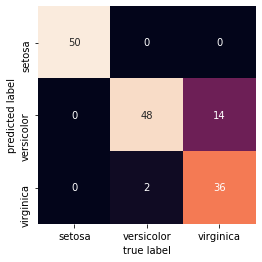

In [ ]:
from sklearn import datasets

# Load the iris dataset
iris = datasets.load_iris()
X = iris.data

from sklearn.decomposition import PCA

# 1. Perform PCA, use 3 components (we will draw it later in 3D)
# ENTER YOUR CODE HERE
projected = 

from sklearn.cluster import KMeans

# 2. Perform k-means
# ENTER YOUR CODE HERE
y = 

### VISUALIZATION CODE ###

import numpy as np
from plotly.subplots import make_subplots
import plotly.graph_objects as go

cmap = {0: 'rgba(0,0,255,255)', 1: 'rgba(0,255,0,255)', 2: 'rgba(255,0,0,255)',
        3: 'rgba(0,0,128,255)', 4: 'rgba(0,128,0,255)', 5: 'rgba(128,0,255)',
        6: 'rgba(0,0,64,255)', 7: 'rgba(0,64,0,255)', 8: 'rgba(64,0,0,255)',
        9: 'rgba(0,0,0,255)'}
colors = [cmap[d] for d in y]

fig = make_subplots(rows=1, cols=1, specs=[[{"type": "scene"}]])

fig.add_trace(go.Scatter3d(x=projected[:, 0], y=projected[:, 1], z=projected[:, 2], mode='markers', 
                           marker=dict(size=4, color=colors)),
              row=1, col=1)

fig.update_layout(width=600, height=600, autosize=False, 
                  title_text="3-component PCA for your dataset",
                  scene={"xaxis": {"title": "component 1"},
                         "yaxis": {"title": "component 2"},
                         "zaxis": {"title": "component 3"}},
                  showlegend=False)
      
fig.show()

#match clusters with real labels
from scipy.stats import mode

labels = np.zeros_like(y)
for i in range(10):
    mask = (y == i)
    labels[mask] = mode(iris.target[mask])[0]
    
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

mat = confusion_matrix(iris.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=iris.target_names,
            yticklabels=iris.target_names)
plt.ylim(3.0, 0.0)
plt.xlabel('true label')
plt.ylabel('predicted label');

# and check the accuracy
from sklearn.metrics import accuracy_score
print("ACCURACY = ", accuracy_score(iris.target, labels))